# [2.X코드반영] Lab 09-1: Neural Net for XOR

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(777)  # for reproducibility

print(tf.__version__)

2.4.1


## XOR 문제

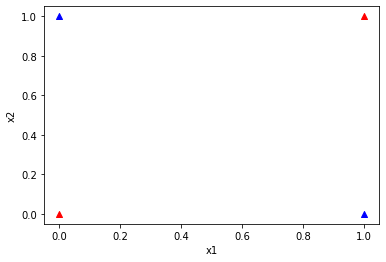

In [2]:
x_data = [[0, 0],
          [0, 1],
          [1, 0],
          [1, 1]]
y_data = [[0],
          [1],
          [1],
          [0]]

plt.scatter(x_data[0][0],x_data[0][1], c='red' , marker='^')
plt.scatter(x_data[1][0],x_data[1][1], c='blue' , marker='^')
plt.scatter(x_data[2][0],x_data[2][1], c='blue' , marker='^')
plt.scatter(x_data[3][0],x_data[3][1], c='red' , marker='^')

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)

preprocess function으로 features,labels는 실재 학습에 쓰일 Data 연산을 위해 Type를 맞춰준다

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(len(x_data))

def preprocess_data(features, labels):
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    return features, labels

## Lab 09 XOR - Logistic Regression

W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([2, 1]) )

In [4]:
W = tf.Variable(tf.zeros((2,1)), name='weight')
b = tf.Variable(tf.zeros((1,)), name='bias')
print('W = {}, B = {}'.format(W.numpy(), b.numpy()))

W = [[0.]
 [0.]], B = [0.]


가설 : 시그모이드 함수

Sigmoid는 아래 그래프와 같이 0과 1의 값만을 리턴합니다 tf.sigmoid(tf.matmul(X, W) + b)와 같습니다

In [5]:
def logistic_regression(features):
    hypothesis = tf.divide(1., 1.+tf.exp(tf.matmul(features, W)+b))
    return hypothesis

비용 함수

In [6]:
def loss_fn(hypothesis, features, labels):
    cost = -tf.reduce_mean(labels*tf.math.log(logistic_regression(features))+(1-labels)*tf.math.log(1-hypothesis))
    return cost

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

Sigmoid 함수를 통해 예측값이 0.5보다 크면 1을 반환하고 0.5보다 작으면 0으로 반환합니다.

In [7]:
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

GradientTape를 통해 경사값을 계산합니다.

In [8]:
def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(logistic_regression(features), features, labels)
    return tape.gradient(loss_value, [W,b])

Tensorflow를 통한 실행을 위해 Session를 선언합니다.

위의 Data를 Cost함수를 통해 학습시킨 후 모델을 생성합니다.

In [9]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels in dataset:
        features, labels = preprocess_data(features, labels)
        grads = grad(logistic_regression(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads, [W,b]))
        if step % 100 == 0:
            print('Iter: {}, Loss: {:.4f}'.format(step, loss_fn(logistic_regression(features), features, labels)))
            
print('W={}, B={}'.format(W.numpy(), b.numpy()))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(logistic_regression(x_data),y_data)
print('Testset accuracy: {:.4f}'.format(test_acc))

Iter: 0, Loss: 0.6931
Iter: 100, Loss: 0.6931
Iter: 200, Loss: 0.6931
Iter: 300, Loss: 0.6931
Iter: 400, Loss: 0.6931
Iter: 500, Loss: 0.6931
Iter: 600, Loss: 0.6931
Iter: 700, Loss: 0.6931
Iter: 800, Loss: 0.6931
Iter: 900, Loss: 0.6931
Iter: 1000, Loss: 0.6931
W=[[0.]
 [0.]], B=[0.]
Testset accuracy: 0.5000


## Lab 09 XOR - Neural Network

위의 Data를 3Layer의 Neural Network를 통해 학습시킨 후 모델을 생성합니다.(강의에서 설명한 구조)

In [10]:
W1 = tf.Variable(tf.random.normal((2,1)), name='weight1')
b1 = tf.Variable(tf.random.normal((1,)), name='bias1')

W2 = tf.Variable(tf.random.normal((2,1)), name='weight2')
b2 = tf.Variable(tf.random.normal((1,)), name='bias2')

W3 = tf.Variable(tf.random.normal((2,1)), name='weight3')
b3 = tf.Variable(tf.random.normal((1,)), name='bias3')

In [11]:
def neural_net(features):
    layer1 = tf.sigmoid(tf.matmul(features, W1)+b1)
    layer2 = tf.sigmoid(tf.matmul(features, W2)+b2)
    layer3 = tf.concat([layer1, layer2],-1)
    hypothesis = tf.sigmoid(tf.matmul(layer3, W3)+b3)
    return hypothesis

def loss_fn(hypothesis, labels):
    cost = -tf.reduce_mean(labels*tf.math.log(hypothesis)+(1-labels)*tf.math.log(1-hypothesis))
    return cost

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis>0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(neural_net(features), labels)
    return tape.gradient(loss_value, [W1,W2,W3,b1,b2,b3])

In [12]:
EPOCHS = 50000

for step in range(EPOCHS):
    for features, labels in dataset:
        features, labels = preprocess_data(features, labels)
        grads = grad(neural_net(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W1,W2,W3,b1,b2,b3]))
        if step % 5000 == 0:
            print('Iter: {}, Loss: {:.4f}'.format(step, loss_fn(neural_net(features), labels)))
            
x_data, y_data = preprocess_data(x_data,y_data)
test_acc = accuracy_fn(neural_net(x_data),y_data)
print('Testset accuracy: {:.4f}'.format(test_acc))

Iter: 0, Loss: 0.8487
Iter: 5000, Loss: 0.6847
Iter: 10000, Loss: 0.6610
Iter: 15000, Loss: 0.6154
Iter: 20000, Loss: 0.5722
Iter: 25000, Loss: 0.5433
Iter: 30000, Loss: 0.5211
Iter: 35000, Loss: 0.4911
Iter: 40000, Loss: 0.4416
Iter: 45000, Loss: 0.3313
Testset accuracy: 1.0000


## Lab 09 XOR - Deep Neural Network

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(len(x_data))
nb_classes = 10

class wide_deep_nn():
  def __init__(self, nb_classes):
    super(wide_deep_nn, self).__init__()

    self.W1 = tf.Variable(tf.random.normal((2,nb_classes)), name='weight1')
    self.b1 = tf.Variable(tf.random.normal((nb_classes,)), name='bias1')

    self.W2 = tf.Variable(tf.random.normal((nb_classes,nb_classes)), name='weight2')
    self.b2 = tf.Variable(tf.random.normal((nb_classes,)), name='bias2')

    self.W3 = tf.Variable(tf.random.normal((nb_classes,nb_classes)), name='weight3')
    self.b3 = tf.Variable(tf.random.normal((nb_classes,)), name='bias3') 

    self.W4 = tf.Variable(tf.random.normal((nb_classes, 1)), name='weight4')
    self.b4 = tf.Variable(tf.random.normal((1,)), name='bias4') 

    self.variables = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]

  def preprocess_data(self, features, labels):
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    return features, labels
  
  def deep_nn(self, features):
    layer1 = tf.sigmoid(tf.matmul(features, self.W1)+self.b1)
    layer2 = tf.sigmoid(tf.matmul(layer1, self.W2)+self.b2)
    layer3 = tf.sigmoid(tf.matmul(layer2, self.W3)+self.b3)
    hypothesis = tf.sigmoid(tf.matmul(layer3, self.W4)+self.b4)
    return hypothesis

  def loss_fn(self, hypothesis, features, labels):
    cost = -tf.reduce_mean(labels*tf.math.log(hypothesis)+(1-labels)*tf.math.log(1-hypothesis))
    return cost

  def accuracy_fn(self, hypothesis, labels):
    predicted = tf.cast(hypothesis>0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

  def grad(self, hypothesis, features, labels):
    with tf.GradientTape() as tape:
      loss_value = self.loss_fn(self.deep_nn(features), features, labels)
    return tape.gradient(loss_value, self.variables)

  def fit(self, dataset, EPOCHS=20000, verbose=500):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    for step in range(EPOCHS):
      for features, labels in dataset:
        features, labels = self.preprocess_data(features,labels)
        grads = self.grad(self.deep_nn(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads, self.variables))
        if step % verbose == 0:
          print('Iter: {}, Loss: {:.4f}'.format(step, self.loss_fn(self.deep_nn(features), features, labels)))
  
  def test_model(self, x_data, y_data):
    x_data, y_data = self.preprocess_data(x_data, y_data)
    test_acc = self.accuracy_fn(self.deep_nn(x_data),y_data)
    print('Testse accuracy: {:.4f}'.format(test_acc))

위의 Data를 4Layer의 Neural Network를 통해 학습시킨 후 모델을 생성합니다.

In [35]:
model = wide_deep_nn(nb_classes)

In [36]:
model.fit(dataset)

Iter: 0, Loss: 0.8959
Iter: 500, Loss: 0.6827
Iter: 1000, Loss: 0.6792
Iter: 1500, Loss: 0.6759
Iter: 2000, Loss: 0.6725
Iter: 2500, Loss: 0.6691
Iter: 3000, Loss: 0.6655
Iter: 3500, Loss: 0.6616
Iter: 4000, Loss: 0.6573
Iter: 4500, Loss: 0.6525
Iter: 5000, Loss: 0.6470
Iter: 5500, Loss: 0.6407
Iter: 6000, Loss: 0.6332
Iter: 6500, Loss: 0.6246
Iter: 7000, Loss: 0.6143
Iter: 7500, Loss: 0.6021
Iter: 8000, Loss: 0.5876
Iter: 8500, Loss: 0.5701
Iter: 9000, Loss: 0.5489
Iter: 9500, Loss: 0.5229
Iter: 10000, Loss: 0.4909
Iter: 10500, Loss: 0.4520
Iter: 11000, Loss: 0.4066
Iter: 11500, Loss: 0.3562
Iter: 12000, Loss: 0.3040
Iter: 12500, Loss: 0.2535
Iter: 13000, Loss: 0.2079
Iter: 13500, Loss: 0.1691
Iter: 14000, Loss: 0.1374
Iter: 14500, Loss: 0.1124
Iter: 15000, Loss: 0.0928
Iter: 15500, Loss: 0.0776
Iter: 16000, Loss: 0.0656
Iter: 16500, Loss: 0.0562
Iter: 17000, Loss: 0.0487
Iter: 17500, Loss: 0.0427
Iter: 18000, Loss: 0.0377
Iter: 18500, Loss: 0.0336
Iter: 19000, Loss: 0.0302
Iter: 1950

In [37]:
model.test_model(x_data, y_data)

Testse accuracy: 1.0000
